In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from DataLoad import DataProcess,LoadSameDuty,DelaySingleData,DelayMultiData


In [2]:
import numpy as np
import glob
def AddDelay(delay,startTime=None,endTime=None,fileName='Static_flow2/*_Apr*.csv'):
    res_data_highTank=[]
    res_data_highCyln=[]
    for file in glob.glob(fileName):
        delayData=pd.DataFrame()
        data = DataProcess(file,startTime=startTime,endTime=endTime)
        
        delayData['cyln_pre'] = data.iloc[:-delay,data.columns.get_loc('cyln_pre')]
        delayData['tank_pre'] = data.iloc[:-delay,data.columns.get_loc('tank_pre')]
        delayData['dCyln_pre'] = np.array(data.iloc[delay:,data.columns.get_loc('dCyln_pre')])
        delayData['dTank_pre'] = np.array(data.iloc[delay:,data.columns.get_loc('dTank_pre')])  
#         pdb.set_trace()
        delayData['duty']=data.iloc[:-delay,data.columns.get_loc('duty')]
        if np.mean(data['cyln_pre'])>np.mean(data['tank_pre']):
            res_data_highCyln.append(delayData)
        else:
            res_data_highTank.append(delayData)
    return pd.concat(res_data_highCyln),pd.concat(res_data_highTank)

In [31]:
data1=DataProcess('Static_flow2/173531_Apr132022.csv')

data2=DataProcess('Static_flow2/175602_Apr132022.csv')
data3=DataProcess('Static_flow2/173716_Apr132022.csv')
data4=DataProcess('Static_flow2/174140_Apr132022.csv',filtered=False)


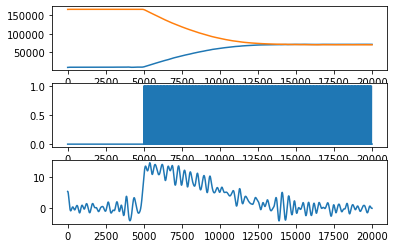

In [32]:
fig,ax = plt.subplots(3,1)
ax[0].plot(data1['time'],data1['cyln_pre'])
ax[0].plot(data1['time'],data1['tank_pre'])
ax[1].plot(data1['time'],data1['val1'])
ax[2].plot(data1['time'],data1['dCyln_pre'])

(4500.0, 5500.0)

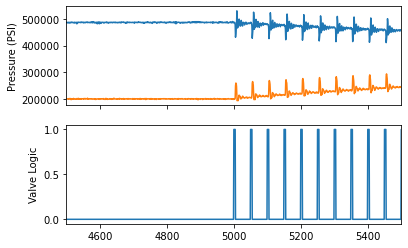

In [33]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(data4['time'],data4['cyln_pre'])
ax[0].plot(data4['time'],data4['tank_pre'])
ax[0].set_ylabel('Pressure (PSI)')
ax[1].plot(data4['time'],data4['val1'])
ax[1].set_ylabel('Valve Logic')
ax[0].set_xlim(4500,5500)

Text(0, 0.5, 'Valve Logic')

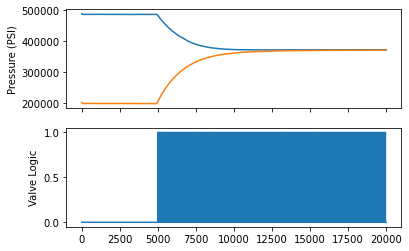

In [30]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(data4['time'],data4['cyln_pre'])
ax[0].plot(data4['time'],data4['tank_pre'])
ax[0].set_ylabel('Pressure (PSI)')
ax[1].plot(data4['time'],data4['val1'])
ax[1].set_ylabel('Valve Logic')


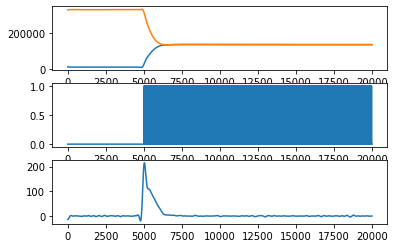

In [6]:
fig,ax = plt.subplots(3,1)
ax[0].plot(data2['time'],data2['cyln_pre'])
ax[0].plot(data2['time'],data2['tank_pre'])
ax[1].plot(data2['time'],data2['val1'])
ax[2].plot(data2['time'],data2['dCyln_pre'])

In [7]:
data_hc,data_ht = AddDelay(200,startTime=5000,endTime=8000)


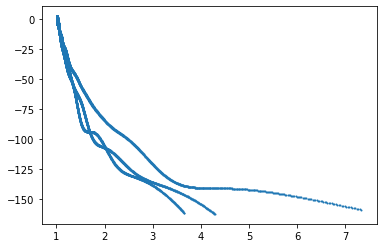

In [8]:
fig,ax = plt.subplots()
cur_data=data_hc[data_hc['duty']==20]
ax.scatter(cur_data['cyln_pre']/cur_data['tank_pre'],cur_data['dCyln_pre'],s=1)


Text(0.5, 1.0, 'Duty=80')

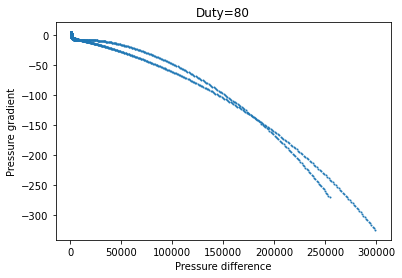

In [38]:
duty_set =80
cur_data=data_hc[data_hc['duty']==duty_set]
fig,ax = plt.subplots()
ax.scatter(cur_data['cyln_pre']-cur_data['tank_pre'],cur_data['dCyln_pre'],s=1)
ax.set_ylabel('Pressure gradient')
ax.set_xlabel('Pressure difference')
ax.set_title('Duty='+str(duty_set))

In [10]:
import pdb
import numpy as np
atm = 101325
def LibCreate(dataList):
    data = pd.concat(dataList,ignore_index=True)
    y = np.array([data['dCyln_pre'],data['dTank_pre']]).T
    
    Theta=np.array([#np.ones([len(data['tank_pre']),]),
                    data['cyln_pre']/atm,
#                     data['tank_pre']/atm*data['duty']/100,
                    data['cyln_pre']*data['tank_pre']/atm**2,
                    data['cyln_pre']/data['tank_pre'],
#                     data['tank_pre']/data['cyln_pre'],
                    (1-data['cyln_pre']/data['tank_pre'])*data['duty']/100,
                    (1-data['cyln_pre']/data['tank_pre'])**2*data['duty']/100,
#                     (1-data['tank_pre']/data['cyln_pre'])*data['duty']/100,
#                     (1-data['tank_pre']/data['cyln_pre'])**2*data['duty']/100,
                    data['cyln_pre']*data['cyln_pre']/data['tank_pre']/atm*data['duty']/100,
#                     data['tank_pre']*data['cyln_pre']/data['tank_pre']/atm*data['duty']/100,
                    data['duty']/100
                   ]).T
    return Theta,y

In [11]:
from sklearn.model_selection import train_test_split
Theta,y = LibCreate([data_hc])
X_train, X_test, y_train, y_test = train_test_split(Theta, y, test_size=0.5, random_state=10)

In [12]:

from sklearn.linear_model import Lasso
model_hc = Lasso(alpha=0.01,max_iter=100000)
print('Number of samples: ',len(X_train))
model_hc.fit(X_train, y_train)
print('R squared training set', round(model_hc.score(X_train, y_train)*100, 2))
print('R squared testing set',round(model_hc.score(X_test,y_test)*100,2))
print(model_hc.sparse_coef_)

Number of samples:  33588
R squared training set 91.88
R squared testing set 92.09
  (0, 0)	-44.46121520145619
  (0, 1)	5.632330265266659
  (0, 2)	25.40304183923802
  (0, 3)	402.6200441347157
  (0, 4)	39.05725558187677
  (0, 5)	13.639562372609557
  (0, 6)	-36.71925725171413
  (1, 0)	62.411026805592996
  (1, 1)	-7.672083314849628
  (1, 2)	-27.682797823828682
  (1, 3)	-517.8608314988282
  (1, 4)	-49.473546076770155
  (1, 5)	-30.409979875219896
  (1, 6)	92.19308641428087


In [13]:
data_test = DataProcess('Static_flow2/175726_Apr132022.csv')
Theta_test,y_test = LibCreate([data_test])
y_predict = model_hc.predict(Theta_test)

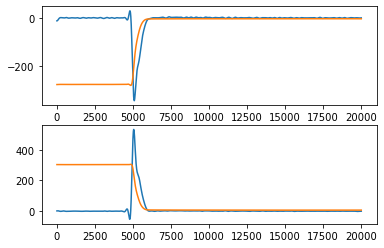

In [14]:
fig,ax=plt.subplots(2,1)
ax[0].plot(data_test['time'],y_test[:,0])
ax[0].plot(data_test['time'],y_predict[:,0])
ax[1].plot(data_test['time'],y_test[:,1])
ax[1].plot(data_test['time'],y_predict[:,1])

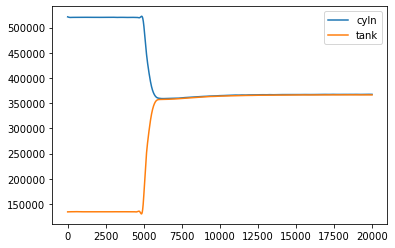

In [15]:
fig,ax=plt.subplots()
ax.plot(data_test['time'],data_test['cyln_pre'],label='cyln')
ax.plot(data_test['time'],data_test['tank_pre'],label='tank')
ax.legend()

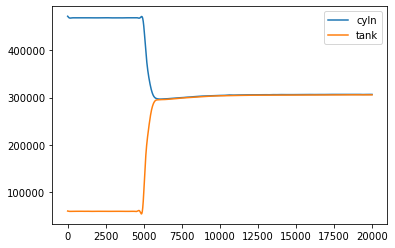

In [16]:
data_test = DataProcess('Static_flow2/180607_Apr132022.csv')
Theta_test,y_test = LibCreate([data_test])
y_predict = model_hc.predict(Theta_test)
fig,ax=plt.subplots()
ax.plot(data_test['time'],data_test['cyln_pre'],label='cyln')
ax.plot(data_test['time'],data_test['tank_pre'],label='tank')
ax.legend()

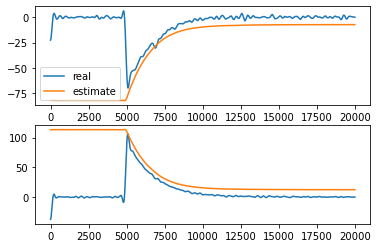

In [40]:
Theta_test,y_test = LibCreate([data_test])
y_predict = model_hc.predict(Theta_test)
fig,ax=plt.subplots(2,1)
ax[0].plot(data_test['time'],y_test[:,0],label='real')
ax[0].plot(data_test['time'],y_predict[:,0],label='estimate')
ax[1].plot(data_test['time'],y_test[:,1])
ax[1].plot(data_test['time'],y_predict[:,1])
ax[0].legend()

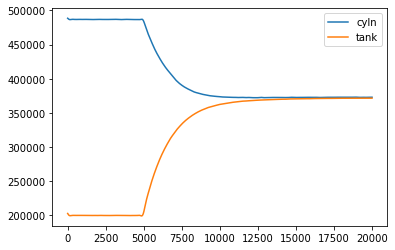

In [18]:
data_test = DataProcess('Static_flow2/174140_Apr132022.csv')
Theta_test,y_test = LibCreate([data_test])
y_predict = model_hc.predict(Theta_test)
fig,ax=plt.subplots()
ax.plot(data_test['time'],data_test['cyln_pre'],label='cyln')
ax.plot(data_test['time'],data_test['tank_pre'],label='tank')
ax.legend()

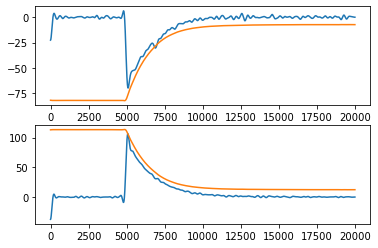

In [19]:
Theta_test,y_test = LibCreate([data_test])
y_predict = model_hc.predict(Theta_test)
fig,ax=plt.subplots(2,1)
ax[0].plot(data_test['time'],y_test[:,0])
ax[0].plot(data_test['time'],y_predict[:,0])
ax[1].plot(data_test['time'],y_test[:,1])
ax[1].plot(data_test['time'],y_predict[:,1])